## PPC spend: causal inference analysis
This notebook uses the tfcausalimpact model to estimate the causal impact of a keyword-specific PPC marketing campaign on relevant product sales. It is based on a real business problem I addressed, but the data has been artificially created for business sensitivity reasons.

References:
* https://github.com/WillianFuks/tfcausalimpact/blob/master/notebooks/getting_started.ipynb
* https://github.com/WillianFuks/tfcausalimpact?tab=readme-ov-file
* https://medium.com/data-science/implementing-causal-impact-on-top-of-tensorflow-probability-c837ea18b126

### Import libaries and functions

In [ ]:
pip install tfcausalimpact

In [1]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact   # import from 'pip install tfcausalimpact'
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

print("✅ All imports successful!")

✅ All imports successful!


### Import pre-processed data

Some pre-processing has already been conducted on the data, including cleaning and basic feature engineering. It can now be imported.

In [125]:
# Import business data (revenue and marketing spend)
business_data = pd.read_csv('https://raw.githubusercontent.com/MikeAspinall/causal-analysis-ppc/main/master_causal_analysis_ppc_data_adjusted.csv')
business_data['date'] = pd.to_datetime(business_data['date'], format='%d/%m/%Y') # Convert date col to datetime
print("✅ Business data imported!\n")
print(business_data.info())
print(business_data.sample(5))

✅ Business data imported!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                956 non-null    datetime64[ns]
 1   dining_revenue      956 non-null    float64       
 2   non_dining_revenue  956 non-null    float64       
 3   ppc_spend           956 non-null    float64       
 4   meta_spend          956 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 37.5 KB
None
          date  dining_revenue  non_dining_revenue  ppc_spend  meta_spend
187 2023-12-30      10654.6482         4264885.177      0.000         0.0
949 2026-01-30       8933.6192         1290111.624    936.837         0.0
258 2024-03-10       5693.9000         1619931.046      0.000         0.0
200 2024-01-12       4626.5296         1340234.764      0.000         0.0
718 2025-06-13       4390.5408         107

In [126]:
# Import search data (Google search trends)
search_data = pd.read_csv('https://raw.githubusercontent.com/MikeAspinall/causal-analysis-ppc/main/causal_analysis_search_data.csv')
search_data = search_data.dropna().reset_index(drop=True) # Drop NaNs
search_data['date'] = pd.to_datetime(search_data['date'], format='%d/%m/%Y') # Convert date col to datetime

# Remove commas from values and convert col formats to float
for col in search_data.columns[1:]:
  search_data[col] = search_data[col].str.replace(',', '').astype(float)

print("✅ Search data imported!\n")
print(search_data.info())
print(search_data.sample(5))

✅ Search data imported!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   30 non-null     datetime64[ns]
 1   search_general         30 non-null     float64       
 2   search_kitchen_dining  30 non-null     float64       
 3   search_living_room     30 non-null     float64       
 4   search_brand_demand    30 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.3 KB
None
         date  search_general  search_kitchen_dining  search_living_room  \
4  2023-11-01        341905.0              2765984.0           4912087.0   
16 2024-11-01        370103.0              2505861.0           4414039.0   
17 2024-12-01        343013.0              2195062.0           3888234.0   
15 2024-10-01        403318.0              2428201.0           4178604.0   
26 2025-09-01   

### Define helper functions

Defining helper functions will streamline the code later on.

In [127]:
def add_day_week_month(df):
  """
  Add day of week, week of year, month to a dataframe
  """
  df['date_temp'] = pd.to_datetime(df.index)
  df['day_of_week'] = df['date_temp'].dt.dayofweek + 1
  df['week_of_year'] = df['date_temp'].dt.isocalendar().week
  df['month'] = df['date_temp'].dt.month
  del df['date_temp']
  return df

In [128]:
def causalimpact_dataprep(data, intervention_date, start_date = None):
    """
    Prepare data for CausalImpact model
    """
    # Filter data to after the start date
    if start_date is not None:
        data = data[data.index >= start_date]
    else:
      pass

    # Define pre-period dates
    pre_period_end = intervention_date - pd.Timedelta(days=1)
    pre_data_subset = data[data.index <= pre_period_end]

    # Ensure pre-period has enough data points
    if len(pre_data_subset) < 3:
        raise ValueError("Pre-period must contain at least 3 data points. Check your start_date and intervention_date or the frequency of your data.")

    pre_period = [
        pre_data_subset.index.min(),
        pre_data_subset.index.max()
    ]

    # Define post-period dates
    post_data_subset = data[data.index >= intervention_date]
    post_period = [
        post_data_subset.index.min(),
        post_data_subset.index.max()
    ]

    return data, pre_period, post_period

    print("✅ Data ready for modelling!")

In [129]:
def run_causalimpact_model(
    data: pd.DataFrame,
    pre_period: list,
    post_period: list,
    model_args: dict = None
):
    """
    Run CausalImpact model on the given data.

    Parameters:
        data (pd.DataFrame): Input dataframe with response & covariates.
        pre_period (list): CausalImpact pre-period [start, end].
        post_period (list): CausalImpact post-period [start, end].
        model_args (dict, optional): Optional overrides for model arguments.

    Returns:
        CausalImpact object
    """

    # Default arguments
    default_args = {
        "seed": 10,
        "standardize": True,
        "niter": 4000,
        "prior_level_sd": 0.1,
        "prior_trend_sd": 0.1,          # Helps stabilise noisy data
        "prior_regression_sd": 0.1,     # Controls how strongly covariates can influence the outcome
        "seasonal_periods": 12,
        "fit_method": "vi",
        'seasonal_initial_scale': 0.1,  # Allows larger amplitude of seasonal spikes (e.g. Christmas)
        'seasonal_drift_scale': 0.01,   # Allows more year-to-year variation of seasonal spikes
    }

    # Allow user to override defaults
    if model_args is not None:
        default_args.update(model_args)

    ci = CausalImpact(
        data,
        pre_period,
        post_period,
        model_args=default_args
    )
    return ci

In [130]:
def print_ci_results(ci):
  """
  Print the results of the CausalImpact model
  """
  print(ci.summary())
  print(ci.summary(output='report'))
  ci.plot()

In [131]:
def print_ci_stats(data: pd.DataFrame, intervention_date, target_col, ci):
  """
  Print detailed statistics of the CausalImpact model
  """
  pre_idx = data.loc[:intervention_date].index
  pre_actual = data.loc[pre_idx, target_col]

  # Extract pre-period predictions from the built in 'ci.inferences' dataframe
  pre_pred = ci.inferences.loc[pre_idx, "complete_preds_means"]
  pre_lower = ci.inferences.loc[pre_idx, "complete_preds_lower"]
  pre_upper = ci.inferences.loc[pre_idx, "complete_preds_upper"]

  r2 = r2_score(pre_actual, pre_pred)
  mae = mean_absolute_error(pre_actual, pre_pred)
  rmse = np.sqrt(mean_squared_error(pre_actual, pre_pred))
  coverage = ((pre_actual >= pre_lower) & (pre_actual <= pre_upper)).mean()

  print(f"Pre-period R²: {r2:.3f}")
  print(f"Pre-period MAE: {mae:.2f}")
  print(f"Pre-period RMSE: {rmse:.2f}")
  print(f"Proportion inside 95% CI: {coverage:.2%}")

  return pre_idx, pre_actual, pre_pred, pre_lower, pre_upper


In [132]:
def plot_causalimpact_graph(pre_idx, pre_actual, pre_pred, pre_lower, pre_upper, title):
  """
  Plot the graph of the CausalImpact model
  """
  plt.figure(figsize=(12,5))
  plt.plot(pre_idx, pre_actual, label="Actual", color="black")
  plt.plot(pre_idx, pre_pred, label="Predicted (BSTS)", color="blue")
  plt.fill_between(pre_idx, pre_lower, pre_upper, color="blue", alpha=0.2, label="95% CI")
  plt.axvline(intervention_date, color="red", linestyle="--", label="Intervention")
  plt.legend()
  plt.title(title)
  plt.show()

In [133]:
def causal_impact_pipeline(data, target_col, intervention_date, start_date, graph_title, model_args: dict = None):
  """
  Run the full causal impact pipeline
  """
  # Prepare the data
  print("➡️ Preparing the data...")
  data, pre_period, post_period = causalimpact_dataprep(data, intervention_date, start_date)

  # Run the model
  print("➡️ Running the CausalImpact model...")
  ci = run_causalimpact_model(data, pre_period, post_period, model_args)

  print("✅ CausalImpact model run successfully! Printing results...\n")

  # Print results
  print_ci_results(ci)

  # Print detailed stats
  pre_idx, pre_actual, pre_pred, pre_lower, pre_upper = print_ci_stats(data, intervention_date, target_col, ci)

  # Plot the results
  plot_causalimpact_graph(pre_idx, pre_actual, pre_pred, pre_lower, pre_upper, graph_title)

---
---
## Data preparation

#### Add bank holidays
Retail sales are often highly influenced by bank holidays, so these will be added to the data and used as a covariate in the modelling.

In [134]:
# Add bank holidays
bank_holidays = ['2023-01-02', '2023-04-07', '2023-04-10', '2023-05-01', '2023-05-08', '2023-05-29', '2023-08-28', '2023-12-25', '2023-12-26',
                '2024-01-01', '2024-03-29', '2024-04-01', '2024-05-06', '2024-05-27', '2024-08-26', '2024-12-25', '2024-12-26',
                '2025-01-01', '2025-04-18', '2025-04-21', '2025-05-05', '2025-05-26', '2025-08-25', '2025-12-25', '2025-12-26',
                '2026-01-01', '2026-04-03', '2026-04-06', '2026-05-04', '2026-05-25', '2026-08-31', '2026-12-25', '2026-12-28'
                ]

business_data['bank_holiday'] = 0

for date in bank_holidays:
    business_data.loc[business_data['date'] == date, 'bank_holiday'] = 1

# Manual inspection to check it has worked
print(f'✅ Examples of bank holidays...\n{business_data[business_data['bank_holiday'] == 1]['date'].sample(3)}')
print(f'\n❎ Examples of non-bank holidays...\n{business_data[business_data['bank_holiday'] != 1]['date'].sample(3)}')

✅ Examples of bank holidays...
336   2024-05-27
277   2024-03-29
280   2024-04-01
Name: date, dtype: datetime64[ns]

❎ Examples of non-bank holidays...
392   2024-07-22
816   2025-09-19
213   2024-01-25
Name: date, dtype: datetime64[ns]


#### Aggregate to monthly
The source dataframes must now be merged. However, the search data is only available in monthly installments, therefore the data must first be aggregated.

In [135]:
# Group business_data into monthly rows on the first of the month, based on 'date' column
business_data_monthly = business_data.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()

# Check monthly aggregation matches the sum of the individual days in the original data
# Iterate over each unique year-month combination present in business_data_monthly
for index, row in business_data_monthly.iterrows():
    year = row['date'].year
    month = row['date'].month

    # Sum from the original daily data for this specific year and month
    sum_original_daily = business_data[(business_data['date'].dt.year == year) & (business_data['date'].dt.month == month)]['dining_revenue'].sum()

    # Get the dining_revenue sum for this specific month from the aggregated dataframe
    sum_aggregated_monthly = row['dining_revenue']

    # Use a tolerance for floating-point comparison
    assert np.isclose(sum_original_daily, sum_aggregated_monthly, atol=1e-9), \
        f'Mismatch for {year}-{month}: Original Daily Sum={sum_original_daily}, Aggregated Monthly Sum={sum_aggregated_monthly}'

print("✅ Monthly aggregation check passed!")
print(business_data_monthly.sample(5))

✅ Monthly aggregation check passed!
         date  dining_revenue  non_dining_revenue   ppc_spend  meta_spend  \
16 2024-10-01     198059.6924        5.754173e+07      0.0000      0.0000   
19 2025-01-01     229579.7461        7.527854e+07      0.0000      0.0000   
2  2023-08-01     211051.4571        4.963375e+07      0.0000      0.0000   
30 2025-12-01     312764.9237        3.976936e+07  25856.7417      0.0000   
10 2024-04-01     168299.8306        4.549601e+07  14190.7288   3543.2244   

    bank_holiday  
16             0  
19             1  
2              1  
30             2  
10             1  


#### Merge
With the data aggregated, the dataframes can now be merged.

In [136]:
data_monthly = pd.merge(business_data_monthly, search_data, on='date', how='left')
assert data_monthly.shape[0] == business_data_monthly.shape[0], 'Merge failed!'

print("✅ Dataframes merged successfully!\n")
print(data_monthly.info())
print(data_monthly.sample(1))

✅ Dataframes merged successfully!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   33 non-null     datetime64[ns]
 1   dining_revenue         33 non-null     float64       
 2   non_dining_revenue     33 non-null     float64       
 3   ppc_spend              33 non-null     float64       
 4   meta_spend             33 non-null     float64       
 5   bank_holiday           33 non-null     int64         
 6   search_general         30 non-null     float64       
 7   search_kitchen_dining  30 non-null     float64       
 8   search_living_room     30 non-null     float64       
 9   search_brand_demand    30 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.7 KB
None
        date  dining_revenue  non_dining_revenue  ppc_spend  meta_spend  \
8 202

Finally, the merged dataframe can be prepared for the causal inference modelling to come. This involves setting the date as the index, removing NaNs in the target column, and adding additional time columns.

In [137]:
# Make a copy of the master_data dataframe
# and set date as index, sort by index, remove index duplicates
bsts_monthly_data = data_monthly.copy()
bsts_monthly_data.index = pd.to_datetime(bsts_monthly_data['date'])
del bsts_monthly_data['date']
bsts_monthly_data = bsts_monthly_data.sort_index()
bsts_monthly_data = bsts_monthly_data[~bsts_monthly_data.index.duplicated()]

In [138]:
# Add month of year using helper function
bsts_monthly_data = add_day_week_month(bsts_monthly_data)
del bsts_monthly_data['day_of_week']
del bsts_monthly_data['week_of_year']

In [139]:
# Create t column, which will be used as a potential covariate in the modelling
bsts_monthly_data['t'] = range(len(bsts_monthly_data))
bsts_monthly_data['t'] = bsts_monthly_data['t'] + 1

In [140]:
bsts_monthly_data.isna().sum()

,0
dining_revenue,0
non_dining_revenue,0
ppc_spend,0
meta_spend,0
bank_holiday,0
search_general,3
search_kitchen_dining,3
search_living_room,3
search_brand_demand,3
month,0


There are a few NaN values in some of the columns. These correspond to weeks where the data was not available. These rows must therefore be dropped.

In [141]:
bsts_monthly_data = bsts_monthly_data.dropna()

---
---
## Exploratory data analysis
Before conducting the modelling, high-level exploratory analysis will be conducted to understand the data, visualise trends, and identify potential issues.

In [142]:
# Set the intervention date - this is when the PPC dining spend increased
intervention_date = pd.Timestamp('2025-07-01')

In [143]:
print(f"Avg post-intervention spend on dining PPC: £{(business_data[business_data['date'] >= intervention_date]['ppc_spend'].mean()):.0f}\n")
print(f"Avg pre-intervention dining-only revenue: £{(business_data[business_data['date'] < intervention_date]['dining_revenue'].mean()):.0f}")
print(f"Avg post-intervention dining-only revenue: £{(business_data[business_data['date'] >= intervention_date]['dining_revenue'].mean()):.0f}")

Avg post-intervention spend on dining PPC: £1003

Avg pre-intervention dining-only revenue: £6107
Avg post-intervention dining-only revenue: £12376


These high level stats show that the average dining-only revenue increased in the post-intervention period. The question is whether this is correlation or causation.

In [144]:
print(f"Total post-intervention spend on dining PPC used for months used in the model:\n\t£{(data_monthly[data_monthly['date'] >= intervention_date]['ppc_spend'].sum()):.0f}\n")
print(f"Monthly avg post-intervention spend on dining PPC used for months used in the model:\n\t£{(data_monthly[data_monthly['date'] >= intervention_date]['ppc_spend'].mean()):.0f}\n")


Total post-intervention spend on dining PPC used for months used in the model:
	£220606

Monthly avg post-intervention spend on dining PPC used for months used in the model:
	£27576



#### Scatter plots

In [145]:
# Define helper function to plot a simple scatter
def plot_scatter(X, y, title):
  mplt.figure(figsize=(4,3))
  mplt.scatter(X, y)
  mplt.xlabel(X.name)
  mplt.ylabel(y.name)
  mplt.title(title)
  mplt.show()

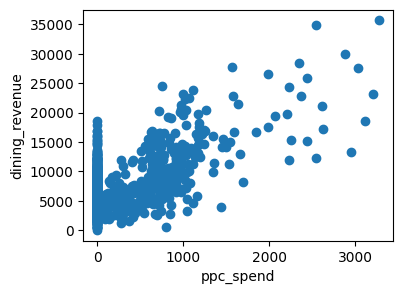


Post-intervention (i.e. excluding ppc_spend = 0) correlation:
	0.64


In [146]:
plot_scatter(business_data['ppc_spend'], business_data['dining_revenue'], '')
business_data['date'] = pd.to_datetime(business_data['date'])

print("\nPost-intervention (i.e. excluding ppc_spend = 0) correlation:")
print(f'\t{business_data[business_data['date'] >= intervention_date]['ppc_spend'].corr(business_data[business_data['date'] >= intervention_date]['dining_revenue']):.2f}')

Next, loop through all columns in the monthly dataframe and plot a scatter of it versus the target column.

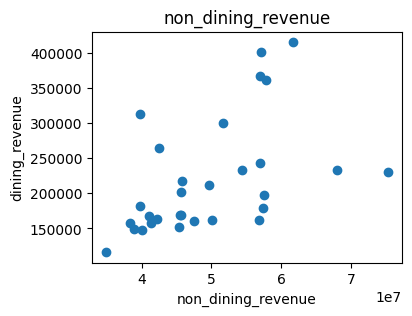

Total correlation: 0.49



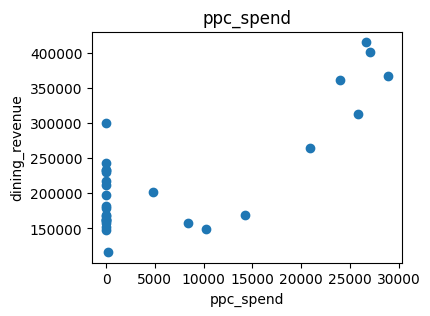

Total correlation: 0.78



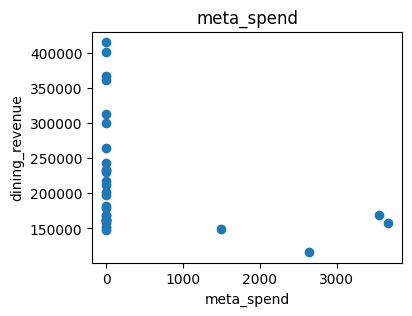

Total correlation: -0.32



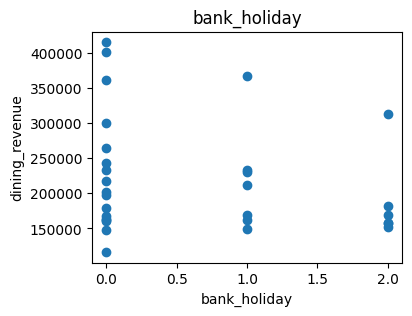

Total correlation: -0.20



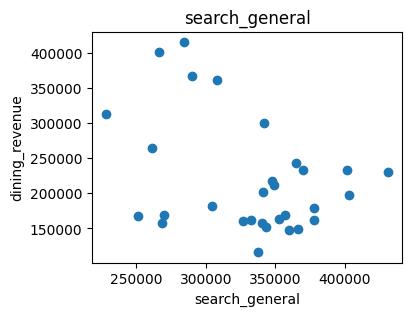

Total correlation: -0.37



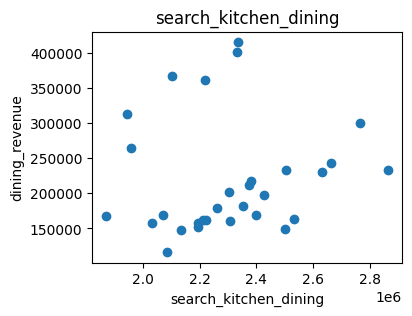

Total correlation: 0.10



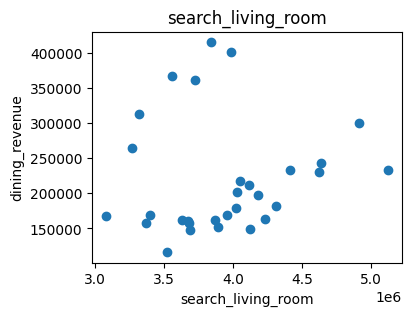

Total correlation: 0.10



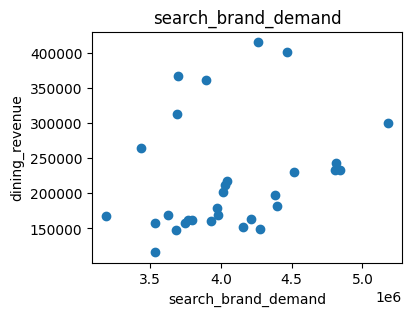

Total correlation: 0.28



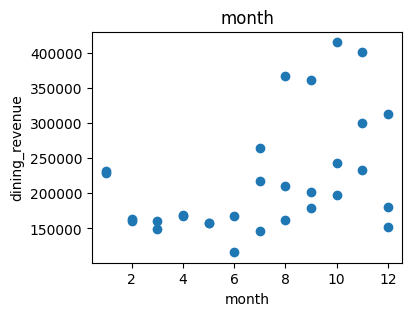

Total correlation: 0.44



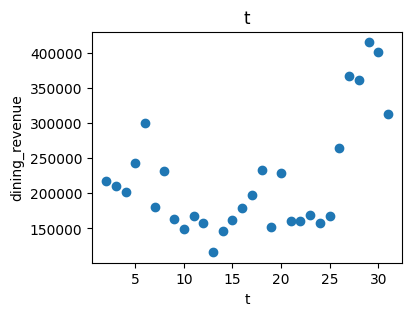

Total correlation: 0.46



In [148]:
for col in bsts_monthly_data:
  if col not in {'dining_revenue'}:
    plot_scatter(bsts_monthly_data[col], bsts_monthly_data['dining_revenue'], col)
    print(f"Total correlation: {(bsts_monthly_data[col].corr(bsts_monthly_data['dining_revenue'])):.2f}\n")

##### **💡Observations**

*   List item
*   List item



#### Line graphs

In [151]:
bsts_monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-07-01 to 2025-12-01
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dining_revenue         30 non-null     float64
 1   non_dining_revenue     30 non-null     float64
 2   ppc_spend              30 non-null     float64
 3   meta_spend             30 non-null     float64
 4   bank_holiday           30 non-null     int64  
 5   search_general         30 non-null     float64
 6   search_kitchen_dining  30 non-null     float64
 7   search_living_room     30 non-null     float64
 8   search_brand_demand    30 non-null     float64
 9   month                  30 non-null     int32  
 10  t                      30 non-null     int64  
dtypes: float64(8), int32(1), int64(2)
memory usage: 2.7 KB


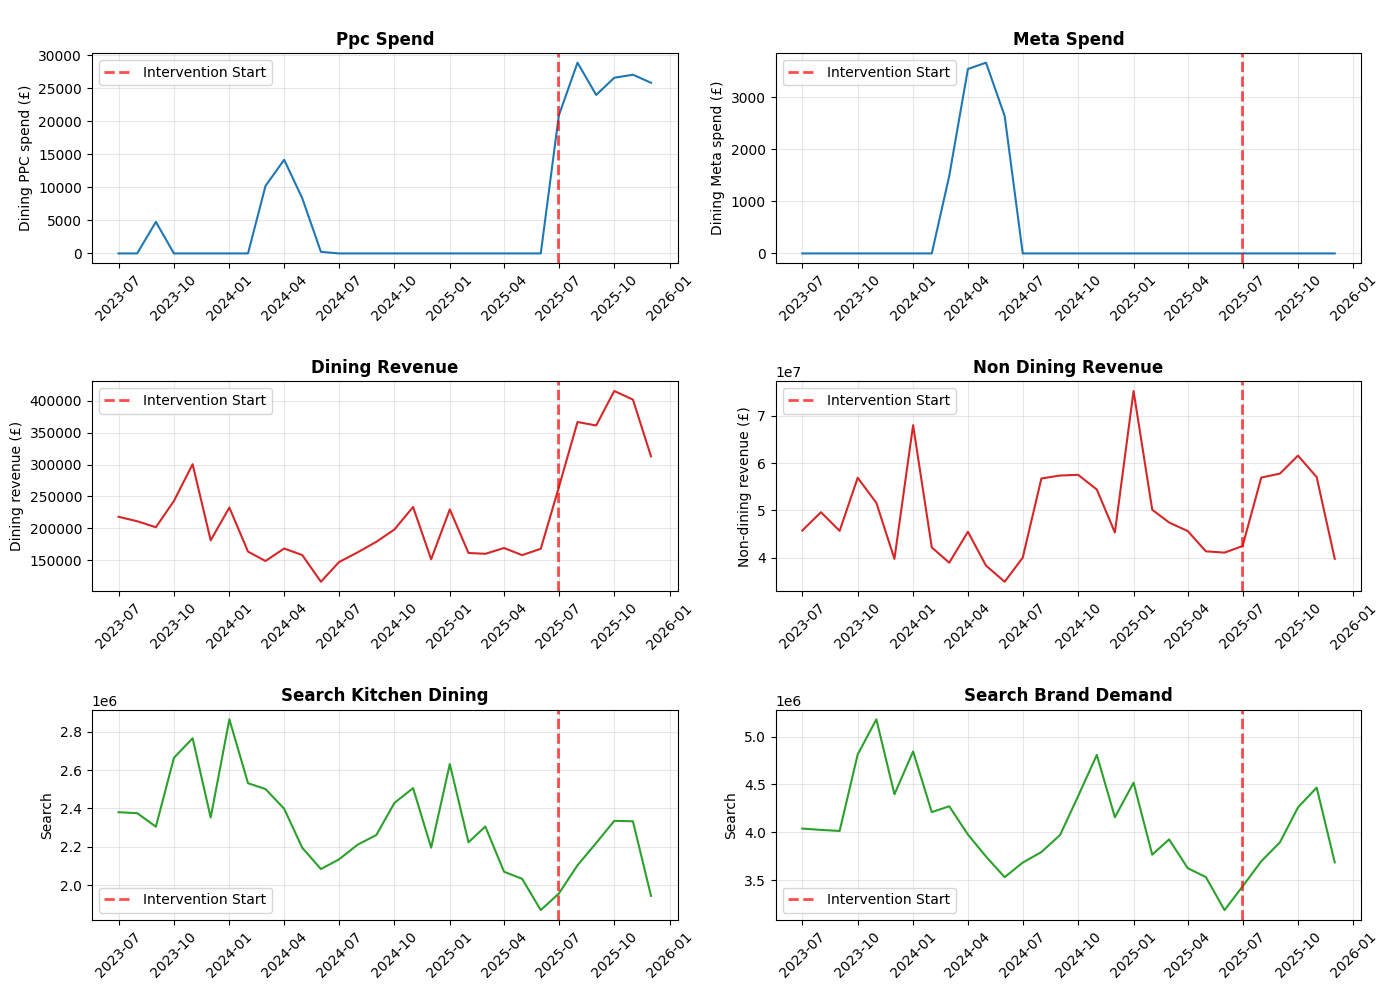

In [158]:
fig, axes = plt.subplots(3,2, figsize=(14, 10))
axes = axes.flatten()

metrics = ["ppc_spend", "meta_spend", "dining_revenue", "non_dining_revenue", "search_kitchen_dining", "search_brand_demand"]
colors = ["#1f77b4", "#1f77b4", "#d62728", "#d62728", "#2ca02c", "#2ca02c"]
axes_titles = ['Dining PPC spend (£)', 'Dining Meta spend (£)', 'Dining revenue (£)', 'Non-dining revenue (£)', 'Search', 'Search']

for ax, metric, color, axis_title in zip(axes, metrics, colors, axes_titles):
    ax.plot(bsts_monthly_data.index, bsts_monthly_data[metric], color=color, linewidth=1.5)
    ax.axvline(
        intervention_date,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label="Intervention Start",
    )
    ax.set_title(
        f"\n{metric.replace('_', ' ').title()}", fontsize=12, fontweight="bold"
    )
    # Rotate x axis labels
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel(axis_title)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()

##### **💡Observations**

*   List item
*   List item

In [ ]:
\haeha

## Modelling with tfcausalimpact

Following the exploratory analysis, we can now turn to the modelling to determine causality of the increased dining PPC spend. The daily data is very noisy and is lacking the search covariates, so is not appropriate for the model. Therefore, the aggregated monthly data will be used.

In [163]:
# Define key dates
intervention_date = pd.Timestamp('2025-07-01')
start_date = pd.Timestamp("2024-07-01")  # Starting on a Monday, ~12 months before the PPC spend increase

#### Test A
To set a baseline, the first test will use minimal covatiates and only 12 months of data.

➡️ Preparing the data...
➡️ Running the CausalImpact model...


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


✅ CausalImpact model run successfully! Printing results...

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    353650.97          2121905.75
Prediction (s.d.)         176169.77 (12889.73)1057018.62 (77338.38)
95% CI                    [150593.74, 201120.56][903562.44, 1206723.4]

Absolute effect (s.d.)    177481.2 (12889.73)1064887.12 (77338.38)
95% CI                    [152530.41, 203057.23][915182.35, 1218343.31]

Relative effect (s.d.)    100.74% (7.32%)    100.74% (7.32%)
95% CI                    [86.58%, 115.26%]  [86.58%, 115.26%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 353650.97. By contrast, in the absence of an
intervention, we would have expected an average response of 176169.77

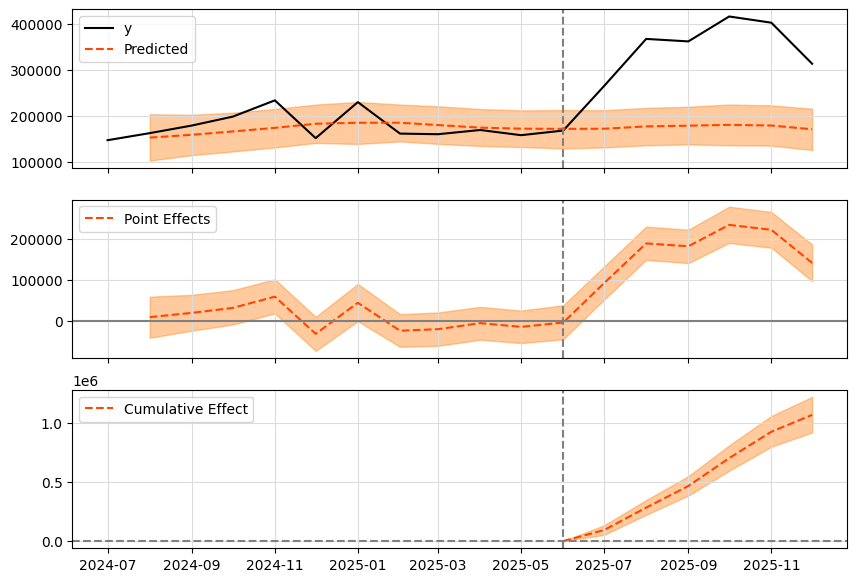

Pre-period R²: -0.090
Pre-period MAE: 27658.91
Pre-period RMSE: 37012.46
Proportion inside 95% CI: 84.62%


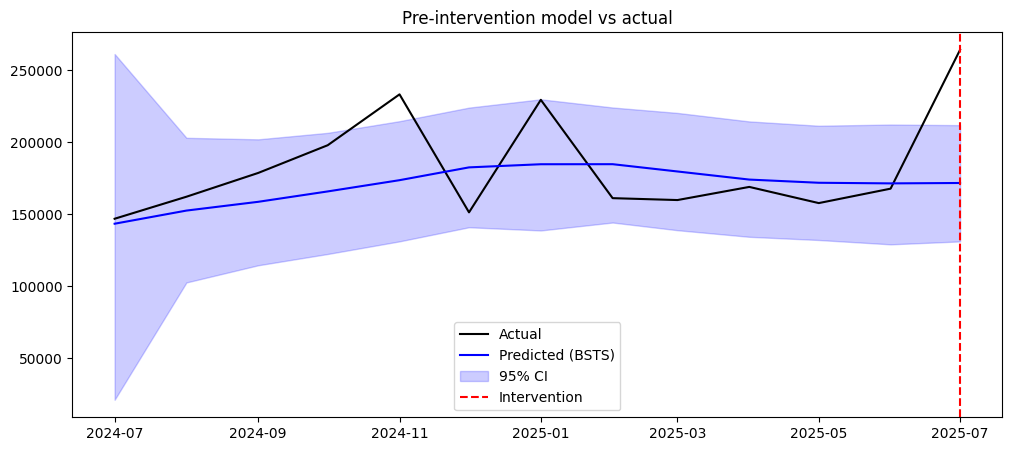

In [164]:
causal_impact_pipeline(bsts_monthly_data[['dining_revenue', 't', 'non_dining_revenue', 'month', 'bank_holiday']], 'dining_revenue', intervention_date, start_date, 'Pre-intervention model vs actual')

#### 💡 Observations
This model has a very poor pre-intervention fit (pre-period R²: -0.090 and proportion inside 95% CI: 84.62%). It has mostly smoothed over the pre-intervention data, and has not captured the seasonal spikes at all. However, it does show a 100% chance of causal uplift in the post-intervention period, which is encouraging. Improving the pre-intervention fit will help give confidence to the causal uplift values.

#### Test B
The time frame will be extended to the earliest point in the data (not just 12 months prior to intervention). However, this introduces months that had non-zero PPC and Meta spend on dining terms, which will impact the target of the modelling. Therefore, PPC and Meta spend on dining will be added as additional columns to attempt to control for this. All other columns remain the same as A.

In [165]:
start_date_earlier = bsts_monthly_data.index.min()

In [ ]:
causal_impact_pipeline(bsts_monthly_data[['dining_revenue', 't', 'non_dining_revenue', 'month', 'bank_holiday', 'ppc_spend', 'meta_spend']], 'dining_revenue', intervention_date, start_date_earlier, 'Pre-intervention model vs actual')

➡️ Preparing the data...
➡️ Running the CausalImpact model...


#### 💡 Observations
This model xxxxxxx

#### D. Monthly, all-time, mask spend
Identical to C, but non-zero PPC and Meta dining spend months will be masked (dropped) to keep the training data clean.

In [ ]:
# Remove months in pre-period where ppc_spend > 0 or meta_spend > 0
bsts_monthly_data_masked = bsts_monthly_data.copy()
mask_contaminated = (bsts_monthly_data_masked.index < intervention_date) & ((bsts_monthly_data_masked['ppc_spend'] > 0) | (bsts_monthly_data_masked['meta_spend'] > 0))
bsts_monthly_data_masked = bsts_monthly_data_masked[~mask_contaminated]

# Check it worked
# Assert that there are no rows in the pre-intervention period where ppc_spend > 0
assert bsts_monthly_data_masked[(bsts_monthly_data_masked.index < intervention_date) & (bsts_monthly_data_masked['ppc_spend'] > 0)].empty, 'Error: PPC spend found in pre-intervention period!'
# Assert that there are no rows in the pre-intervention period where meta_spend > 0
assert bsts_monthly_data_masked[(bsts_monthly_data_masked.index < intervention_date) & (bsts_monthly_data_masked['meta_spend'] > 0)].empty, 'Error: Meta spend found in pre-intervention period!'

In [ ]:
start_date_earlier = bsts_monthly_data_masked.index.min()

In [ ]:
causal_impact_pipeline(bsts_monthly_data_masked[['dining_only_revenue', 't', 'non_dining_revenue', 'month', 'bank_holiday']], 'dining_only_revenue', intervention_date, start_date_earlier, 'Pre-intervention model vs actual')

#### E. Monthly, all-time, with search
As per test D, but with the search demand columns added as covariates

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue', intervention_date, start_date_earlier, 'Pre-intervention model vs actual')

In [ ]:
WERHAETJSRJ

#### F. Tune model hyperparameters 1
As per test E, but with different (manually specified) model hyperparameters

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc' # Hamiltonian Monte Carlo, reference: https://github.com/WillianFuks/tfcausalimpact?tab=readme-ov-file
                                   })

HMC fit method has notably improved the results.

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'prior_level_sd': 0.01 # Controls how much the baseline level of the time series is allowed to fluctuate over time
                                   })

Setting 'prior_level_sd': 0.01 has not improved the results, so 'prior_level_sd': 0.1 will continue to be used.

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

Adjusting 'prior_regression_sd' to 0.01 has helped, but the model is still struggling to fit to the sharp peaks and troughs of December/January sales. Therefore, seasonal_initial_scale and seasonal_drift_scale will be tuned next.

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 5,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 50,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 100,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

Increasing seasonal_initial_scale does not appear to be improving the results any further.

## Model verification

Run the model against non-dining sales - is the model indicating that dining PPC spend has increased non-dining sales?

In [ ]:
# Make a copy of the dataframe, and move the new target column to the front
test_df = bsts_monthly_data_masked.copy()
col = test_df.pop('non_dining_revenue')
test_df.insert(0, 'non_dining_revenue', col)

In [ ]:
causal_impact_pipeline(test_df.drop(['dining_only_revenue', # Must drop now as it's not longer the target col
                                     'ppc_spend', 'meta_spend'], axis=1),
                       'non_dining_revenue', # Specify new target column
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 100,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01
                                   })